# Differential TF activity

In [2]:
import gzip
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Load matched set of data

Using top 10 % of DNase peaks from both HepG2 and K562
Both should be using exactly the same set of positions.

In [3]:
deep_k562 = {} # chrom -> position -> score
files = ['/mnt/dnase/hepg2_deeplift_1_20000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_1_40000.tsv.gz',
         '/mnt/dnase/k562_deeplift_1_20000.tsv.gz',
         '/mnt/dnase/k562_deeplift_1_40000.tsv.gz',
        ]
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep_k562:
                deep_k562[chrom] = {}
            deep_k562[chrom][int(pos)] = float(score)

In [4]:
deep_hepg2 = {} # chrom -> position -> score
files = ['/mnt/dnase/hepg2_deeplift_20000.tsv.gz',
         '/mnt/dnase/hepg2_deeplift_40000.tsv.gz',
         '/mnt/dnase/k562_deeplift_20000.tsv.gz',
         '/mnt/dnase/k562_deeplift_40000.tsv.gz',
        ]
for fn in files:
    with gzip.open(fn) as fp:
        for line in fp:
            chrom, pos, score = line.strip().split()
            if chrom not in deep_hepg2:
                deep_hepg2[chrom] = {}
            deep_hepg2[chrom][int(pos)] = float(score)

# Load set of ENCODE TFBS

Just keep the relavent ones, so we don't run out of RAM...

In [5]:
encode = {}
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if chrom not in deep_hepg2: continue
        if start not in deep_hepg2[chrom]: continue
        for pos in range(start, end):
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)

# Create lists of activities for each TF

The resulting lists are matched exactly, so later our
T-test for differential activity will be fair.

In [6]:
k562_encode = {}
hepg2_encode = {}

for chrom, positions in deep_hepg2.items():
    if chrom == 'chrY': continue
    for pos, score in positions.items():
        if pos in encode[chrom]:
            for motif in encode[chrom][pos]:
                if not motif in k562_encode:
                    k562_encode[motif] = []
                    hepg2_encode[motif] = []
                k562_encode[motif]  += [deep_k562[chrom][pos]]
                hepg2_encode[motif] += [score]

-0.00082943971092 0.00050933741525 ZBTB33_known1
-0.000186227494457 -0.000673755090965 ZBTB33_disc4
0.109174534623 0.104925179949 ZBTB33_disc1
0.00428754952673 0.00515814472821 ZBTB33_disc3
0.00671071216251 0.0115615502661 ZBTB33_disc2
SpearmanrResult(correlation=0.75724042210638776, pvalue=0.0)
LinregressResult(slope=0.98068117153622381, intercept=0.00016352210003696237, rvalue=0.96956481176933806, pvalue=0.0, stderr=0.0056340482909404419)


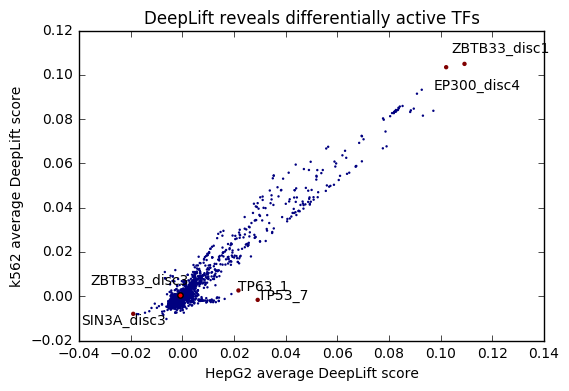

In [33]:
hepG2, k562, names, p = [], [], [], []

for motif, k in k562_encode.items():
    h = hepg2_encode[motif]
    hepG2 += [sum(h) / float(len(h))]
    k562  += [sum(k) / float(len(k))]
    names += [motif]#.split('_')[0]]
    p += [stats.ttest_rel(h, k)[1]]
    if motif.split('_')[0] == 'ZBTB33': print hepG2[-1], k562[-1], motif

high = ['ZBTB33_disc1', 'EP300_disc4', 'TP53_7', 'TP63_1', 'SIN3A_disc3', 'ZBTB33_disc4'] 
c = np.zeros(len(names))
s = np.array([3] * len(names))

for h in high:
    c[names.index(h)] = 1
    s[names.index(h)] = 10

fig, ax = plt.subplots()
cs = ax.scatter(hepG2, k562, c= c, s = s, lw = 0) # c = np.array(p) < float('1e-5') / float(len(hepG2))

for i, txt in enumerate(names):
    if hepG2[i] > .02 and k562[i] < 0.01:
        shift = 0
        if txt == 'TP53': shift = -.008
        ax.annotate(txt, (hepG2[i], k562[i] + shift))
    if hepG2[i] > .1 and k562[i] > 0.1:
        shift = 0.005
        if txt[:2] == 'EP': shift = -.01
        ax.annotate(txt, (hepG2[i] - .005, k562[i] + shift))  
    if hepG2[i] <  - .019 and k562[i] <  0:
        ax.annotate(txt, (hepG2[i] - .02, k562[i]-.005))
        
    if txt == 'ZBTB33_disc3':
        ax.annotate(txt, (hepG2[i]-.04, k562[i]))
plt.scatter([-0.00082943971092],[0.00050933741525], c = 'r', s = 15)
print stats.spearmanr(hepG2, k562)
print stats.linregress(hepG2, k562)
plt.title('DeepLift reveals differentially active TFs')
plt.xlabel('HepG2 average DeepLift score')
plt.ylabel('k562 average DeepLift score')
plt.ylim(-.02, 0.12)
plt.show()

In [8]:
hepG2, k562, names, p = [], [], [], []
merged_hepg2, merged_k562 = {}, {}

for motif, k in k562_encode.items():
    h = hepg2_encode[motif]
    name = motif.split('_')[0]
    if name not in merged_hepg2:
        merged_hepg2[name] = []
        merged_k562[name] = []
    merged_hepg2[name] += h
    merged_k562[name] += k

for motif, k in merged_k562.items():
    h = merged_hepg2[motif]
    hepG2 += [sum(h) / float(len(h))]
    k562  += [sum(k) / float(len(k))]
    names += [motif.split('_')[0]]
    p += [stats.ttest_rel(h, k)[1]]
    
fig, ax = plt.subplots()
cs = ax.scatter(hepG2, k562, , s = 10, lw = 0) # c = np.array(p) < float('1e-5') / float(len(hepG2))

for i, txt in enumerate(names):
    if hepG2[i] > .02 and k562[i] < 0.01:
        shift = 0
        if txt == 'TP53': shift = -.005
        ax.annotate(txt, (hepG2[i], k562[i] + shift))
    if hepG2[i] > .1 and k562[i] > 0.1:
        shift = 0
        if txt[:2] == 'EP': shift = -.01
        ax.annotate(txt, (hepG2[i], k562[i] + shift))  
    if hepG2[i] <  - .019 and k562[i] <  0:
        ax.annotate(txt, (hepG2[i] - .017, k562[i]))
        
    if hepG2[i] < 0 and k562[i] >  .011:
        ax.annotate(txt, (hepG2[i] - .02, k562[i] + .005))

print stats.spearmanr(hepG2, k562)
print stats.linregress(hepG2, k562)
plt.title('DeepLift reveals differentially active TFs')
plt.xlabel('HepG2 average DeepLift score')
plt.ylabel('k562 average DeepLift score')
plt.show()

SyntaxError: invalid syntax (<ipython-input-8-d3cb279e8762>, line 21)

# The below can be used to get the DeepLIFT FP of a given TF

In [ ]:
#activity = np.zeros((60,))
with gzip.open('/mnt/matches.txt.gz') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        print end, start
        break
        if motif != 'ZBTB33_disc1': continue
        start, end = int(start), int(end)
        if chrom not in deep_hepg2: continue
        if start-20 not in deep_hepg2[chrom]: continue
        if end+20 not in deep_hepg2[chrom]: continue
        for i, pos in enumerate(range(start-20, end+20)):
            activity[i] += deep_hepg2[chrom][pos] if pos in deep_hepg2[chrom] else 0
            

In [ ]:
plt.plot(range(-49/ 2, 49 / 2), activity[:49])
plt.title("ZBTB33 Deeplift Meta Plot")
plt.show()

# Does differential activity correspond to Expression?

1. Restrict to TFs above an activity threshold
2. 

In [34]:
def read_expression(fn):
    out = {}
    with open(fn) as fp:
        for line in fp:
            chrom, start, end, n1, color, strand, expression, ensemble, common = line.strip().split()[:9]
            expression = float(expression)
            out[common] = max(expression, out[common]) if common in out else expression
    return out


hepg2_rep1 = read_expression('/mnt/ENCFF171WDX_hepg2.tsv')
k562_rep1  = read_expression('/mnt/ENCFF169EPT.tsv')

hepg2_rep2 = read_expression('/mnt/ENCFF304DLV_hepg2.tsv')
k562_rep2  = read_expression('/mnt/ENCFF657ZGQ.tsv')

In [35]:
def arcsinh_or_zero(d, x):
    if x in d: return np.arcsinh(d[x])
    return 0

In [76]:
hepg2 = {i:(arcsinh_or_zero(hepg2_rep1, i) + arcsinh_or_zero(hepg2_rep2, i)) / 2 for i in hepg2_rep1.keys()}
k562  = {i:(arcsinh_or_zero(k562_rep1, i) + arcsinh_or_zero(k562_rep2, i)) / 2 for i in k562_rep1.keys()}

In [77]:
hepG2_tf, k562_tf, names, p = [], [], [], []
h_exp, k_exp = [], []
for motif, k in k562_encode.items():
    h = hepg2_encode[motif]
    name = motif.split('_')[0]
    if (name not in hepg2) and (name not in k562): continue
    h_exp += [hepg2[name] if name in hepg2 else 0]
    k_exp += [k562[name] if name in k562 else 0]
    hepG2_tf += [sum(h) / float(len(h))]
    k562_tf  += [sum(k) / float(len(k))]
    names += [motif]#.split('_')[0]]
    p += [stats.ttest_rel(h, k)[1]]

In [94]:
f_h_e, f_k_e, f_h_t, f_k_t = [], [], [], []
for h_e, k_e, h_t, k_t in zip(h_exp, k_exp, hepG2_tf, k562_tf):
    if h_e < .5 and k_e < .5: continue
    if h_t < .005 and k_t < .005: continue
    f_h_e += [h_e]
    f_k_e += [k_e]
    f_h_t += [h_t]
    f_k_t += [k_t]

SpearmanrResult(correlation=0.21417111698248362, pvalue=0.00031432274939996658)
LinregressResult(slope=44.001420449849995, intercept=-0.33516398117490775, rvalue=0.15169127826380741, pvalue=0.011178564450326091, stderr=17.227061575642733)


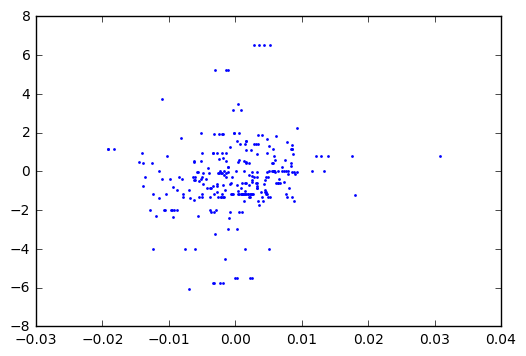

In [95]:
t = [(i-j) for i, j in zip(f_h_t, f_k_t)]
e = [(i-j) for i, j in zip(f_h_e, f_k_e)]

s_t = t#[i for i in t if abs(i) > .001]
s_e = e#[j for i, j in zip(t, e) if abs(i) > .001]

plt.scatter(s_t, s_e, s = 4, lw = 0)
print stats.spearmanr(s_t, s_e)
print stats.linregress(s_t, s_e)

SpearmanrResult(correlation=-0.04381827610629789, pvalue=0.44278311541467763)

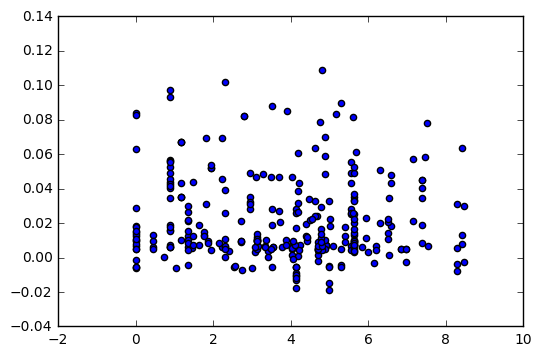

In [92]:
plt.scatter(f_h_e, f_h_t)
stats.spearmanr(f_h_e, f_h_t)

SpearmanrResult(correlation=-0.048478649151698798, pvalue=0.39575745953303776)

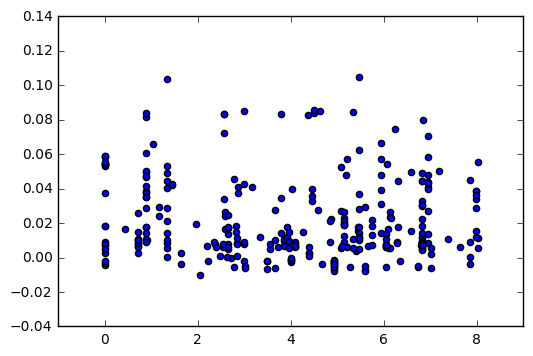

In [93]:
plt.scatter(f_k_e, f_k_t)
stats.spearmanr(f_k_e, f_k_t)